In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_colwidth', 80)

import re
import string
import nltk
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

import seaborn as sb
sb.set_style('whitegrid')

from scipy import stats

In [2]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,7

## Load data

In [3]:
train = pd.read_csv('train.csv')
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours in...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STf...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even i...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal....,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# Drop columns that won't be analyzed
train.drop(['id', 'keyword', 'location'], axis=1, inplace=True)

## Create meta features

In [6]:
#Calculate the number of characters on a tweet excluding spaces
train['tweet_len'] = train['text'].apply(lambda x: len(x) - x.count(' '))

#Calculate the number of hashtags on a tweet
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c=='#']))

#Classify the tweet according to presence of hashtags (1:yes, 0: no)
train['hashtag_yn'] = train['hashtag_count'].apply(lambda x: np.where(x>0, 1, 0))

#Calculate the number of mentions on a tweet
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

#Classify the tweet according to presence of mentions (1:yes, 0: no)
train['mention_yn'] = train['mention_count'].apply(lambda x: np.where(x>0, 1, 0))

#Calculate the number of characters that belong to punctuation signs/marks
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#Classify the tweet according to presence of punctuation (1:yes, 0: no)
train['punctuation_yn'] = train['punctuation_count'].apply(lambda x: np.where(x>0, 1, 0))

#Calculate the number of words on a tweet
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))

#Calculate the number of unique words on a tweet
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))

#Calculate the number of stop words on a tweet
train['stopword_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOP_WORDS]))

#Calculate the number of urls on a tweet
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

#Classify the tweet according to presence of urls (1:yes, 0: no)
train['url_yn'] = train['url_count'].apply(lambda x: np.where(x>0, 1, 0))

#Calculate the average word length on a tweet
train['avg_word_len'] = train['text'].apply(lambda x: round(np.mean([len(w) for w in str(x).split()]),2))

train

,text,target,tweet_len,hashtag_count,hashtag_yn,mention_count,mention_yn,punctuation_count,punctuation_yn,word_count,unique_word_count,stopword_count,url_count,url_yn,avg_word_len
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,57,1,1,0,0,1,1,13,13,6,0,0,4.38
1,Forest fire near La Ronge Sask. Canada,1,32,0,0,0,0,1,1,7,7,0,0,0,4.57
2,All residents asked to 'shelter in place' are being notified by officers. No...,1,112,0,0,0,0,3,1,22,20,11,0,0,5.09
3,"13,000 people receive #wildfires evacuation orders in California",1,57,1,1,0,0,2,1,8,8,1,0,0,7.12
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours in...,1,72,2,1,0,0,2,1,16,15,7,0,0,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STf...,1,73,0,0,0,0,5,1,11,11,2,1,1,6.64
7609,@aria_ahrary @TheTawniest The out of control wild fires in California even i...,1,106,0,0,2,1,5,1,20,17,9,0,0,5.30
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,58,0,0,0,0,11,1,8,8,2,1,1,7.25
7611,Police investigating after an e-bike collided with a car in Little Portugal....,1,119,0,0,0,0,5,1,19,19,5,0,0,6.26


## Plot histograms of the created meta features

In [7]:
def hist_plot_function(column):
    #Divide the train dataset according to the target variable (0 or 1).
    a = train[train['target']==0][column].values
    b = train[train['target']==1][column].values
    
    #Calculate the T-test for the means of both groups.
    print(stats.ttest_ind(a, b, equal_var=False))
    
    #Create histograms for both groups on the same figure
    plt.title(column)
    plt.hist(a, alpha=0.5, density=True, label='not disaster')
    plt.hist(b, alpha=0.5, density=True, label='disaster')
    plt.legend(loc='best')
    plt.show()

Ttest_indResult(statistic=-18.552410449296456, pvalue=3.5791996060605243e-75)


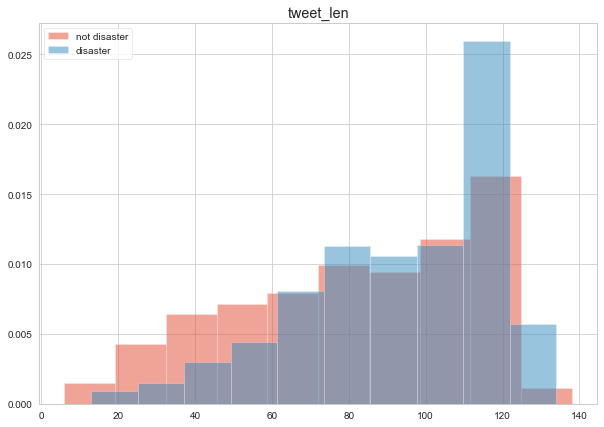

Ttest_indResult(statistic=-4.953220497150671, pvalue=7.489786192994653e-07)


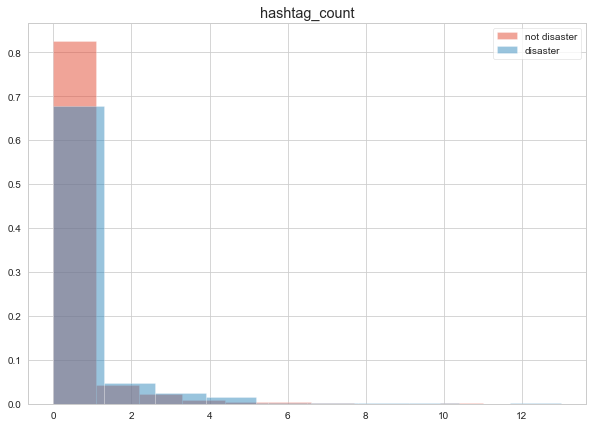

Ttest_indResult(statistic=-6.431117161163684, pvalue=1.3543550627782149e-10)


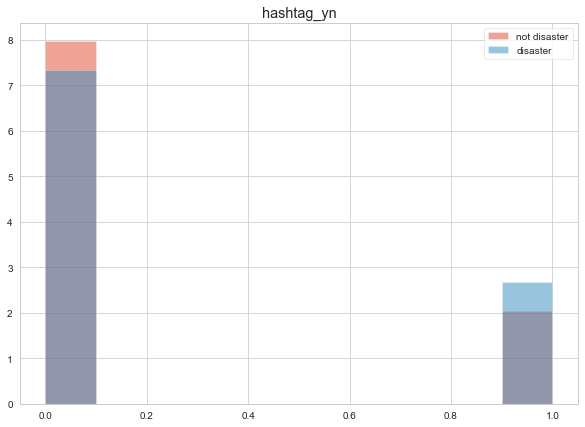

Ttest_indResult(statistic=9.329414166899953, pvalue=1.372471240805839e-20)


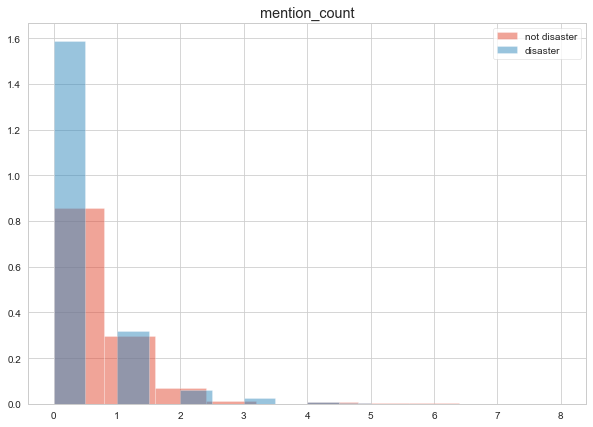

Ttest_indResult(statistic=10.7379183704853, pvalue=1.0586450183474747e-26)


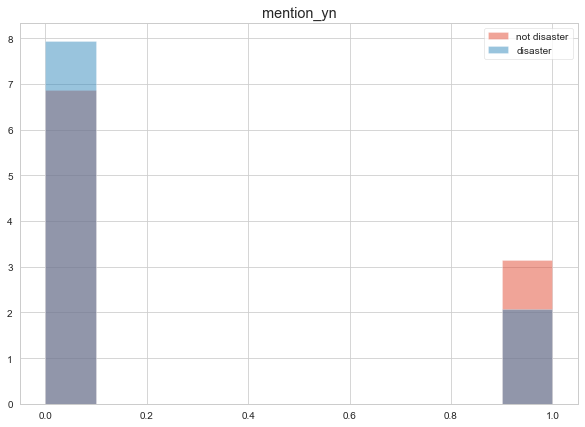

Ttest_indResult(statistic=-11.903912819660958, pvalue=2.2156694628883537e-32)


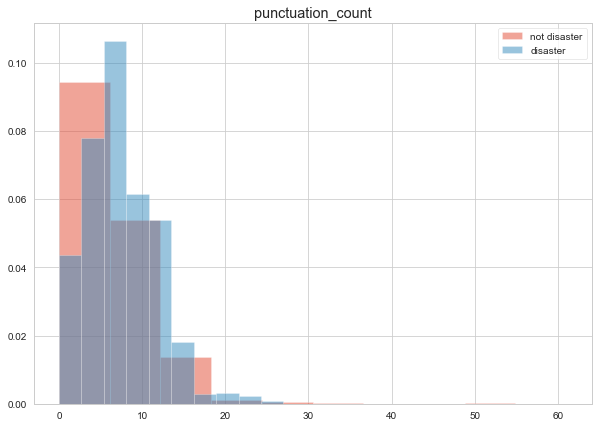

Ttest_indResult(statistic=-9.76102356201562, pvalue=2.2801369826957385e-22)


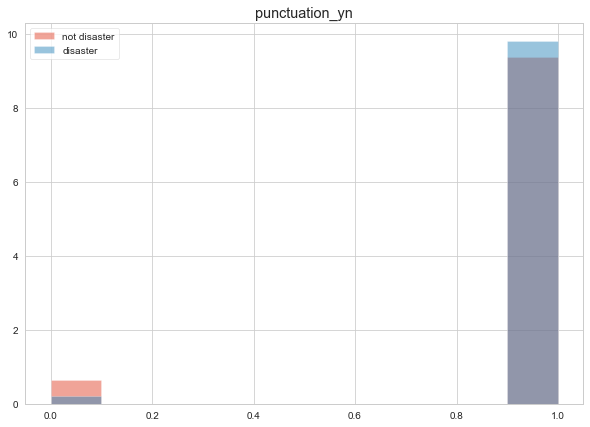

Ttest_indResult(statistic=-3.5827341440382523, pvalue=0.0003421596979870606)


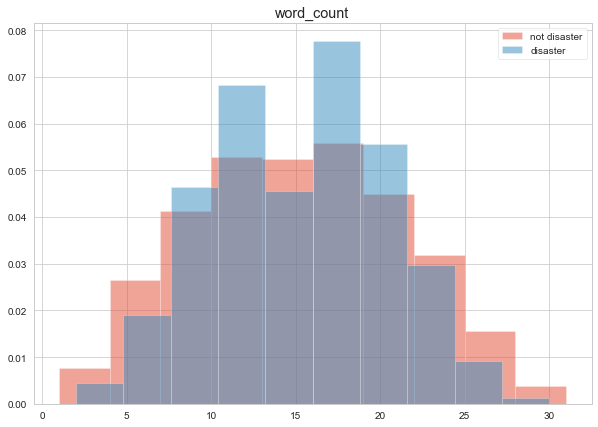

Ttest_indResult(statistic=-4.778767395366659, pvalue=1.797127049027708e-06)


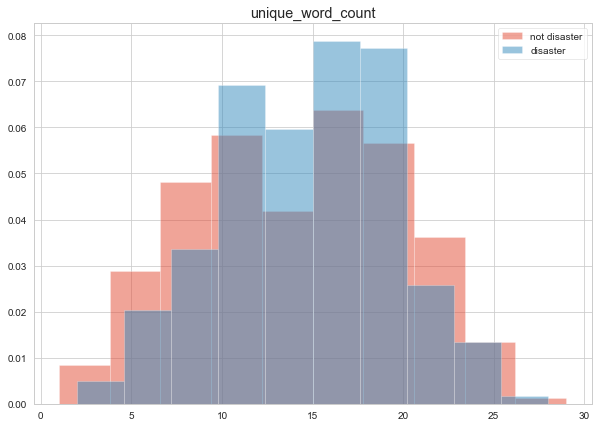

Ttest_indResult(statistic=8.875095987137843, pvalue=8.622747411999423e-19)


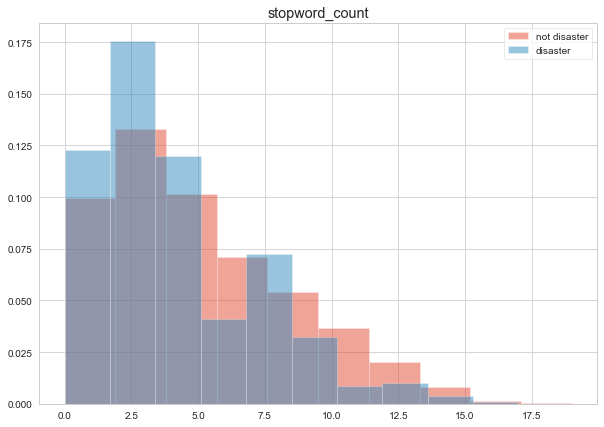

Ttest_indResult(statistic=-17.539903857541645, pvalue=1.7317786641919075e-67)


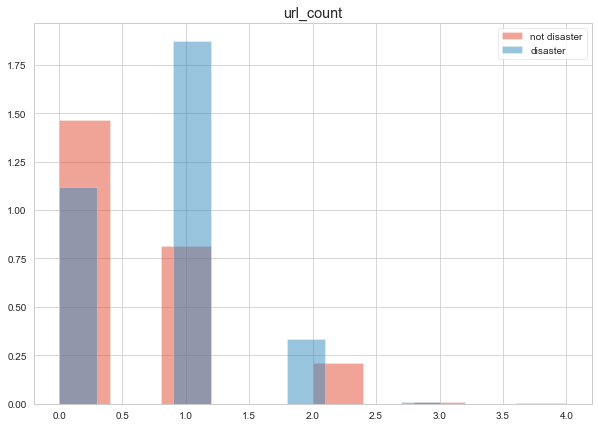

Ttest_indResult(statistic=-22.411673734734613, pvalue=1.373041252538912e-107)


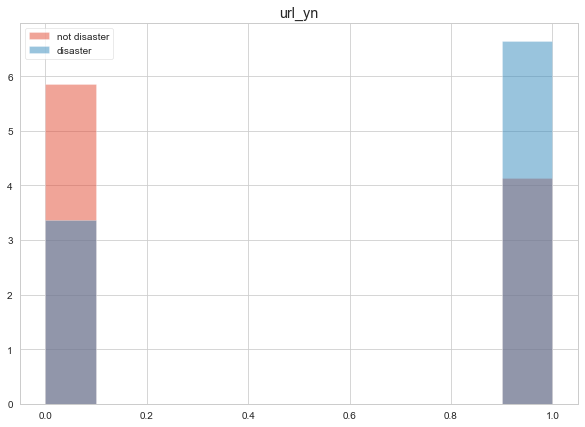

Ttest_indResult(statistic=-15.981940590967973, pvalue=1.4750739635911822e-56)


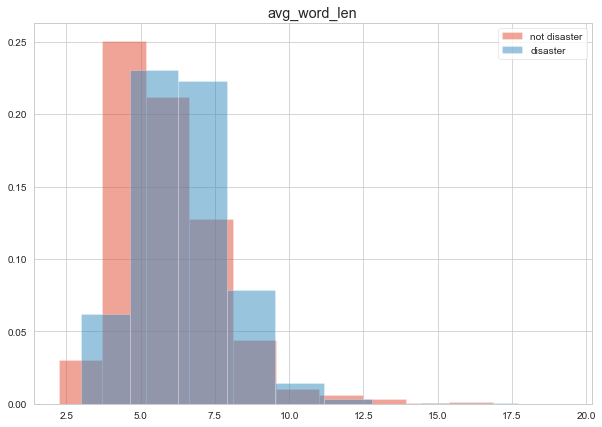

In [8]:
for column in train.columns[2:]:
    hist_plot_function(column)

## Text processing

In [9]:
def process_text(text):
    # Make text lowercase
    text = text.lower()
    # Remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    # Remove mentions
    text = re.sub('@\S+', '', text)
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text) 
    # Remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    # Tokenization
    tokens = re.split('\W+', text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in STOP_WORDS]
    # Remove short tokens
    tokens = [word for word in tokens if len(word)>2]
    text = ' '.join(tokens)
    return text

In [10]:
#Apply the process_text function on a raw tweet
train['processed_text'] = train['text'].apply(lambda x: process_text(x))

#Calculate the number of characters on a tweet excluding spaces
train['processed_tweet_len'] = train['processed_text'].apply(lambda x: len(x) - x.count(' '))

#Calculate the number of words on a tweet
train['processed_word_count'] = train['processed_text'].apply(lambda x: len(str(x).split()))

#Calculate the number of unique words on a tweet
train['processed_unique_word_count'] = train['processed_text'].apply(lambda x: len(set(str(x).split())))

#Calculate the average word length on a tweet
train['processed_avg_word_len'] = train['processed_text'].apply(lambda x: round(np.mean([len(w) for w in str(x).split()]),2))
train['processed_avg_word_len'].fillna(0, inplace=True)

train.isnull().sum()

C:\Users\rober\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


text                           0
target                         0
tweet_len                      0
hashtag_count                  0
hashtag_yn                     0
mention_count                  0
mention_yn                     0
punctuation_count              0
punctuation_yn                 0
word_count                     0
unique_word_count              0
stopword_count                 0
url_count                      0
url_yn                         0
avg_word_len                   0
processed_text                 0
processed_tweet_len            0
processed_word_count           0
processed_unique_word_count    0
processed_avg_word_len         0
dtype: int64

Ttest_indResult(statistic=-18.28331562647583, pvalue=4.6040104909310724e-73)


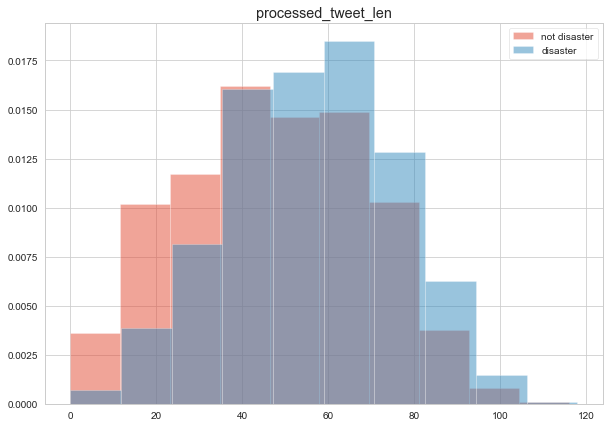

Ttest_indResult(statistic=-11.123116551189279, pvalue=1.6230753874171583e-28)


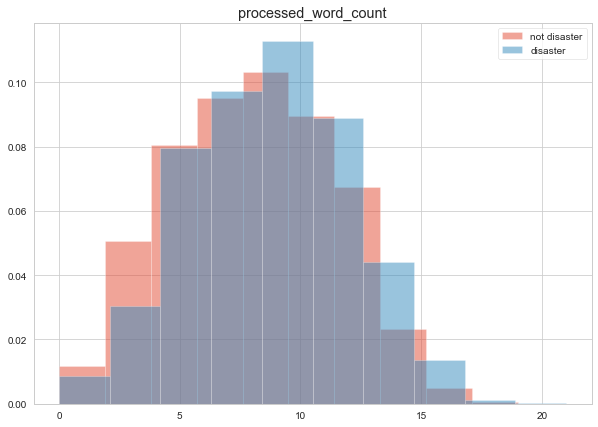

Ttest_indResult(statistic=-10.490958980231994, pvalue=1.4304015429537798e-25)


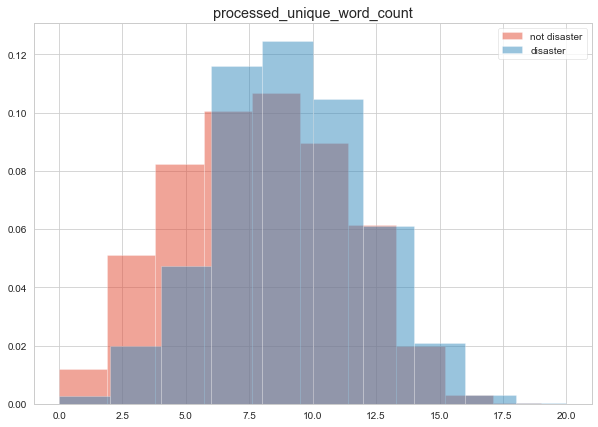

Ttest_indResult(statistic=-10.390149889617302, pvalue=4.299734228703451e-25)


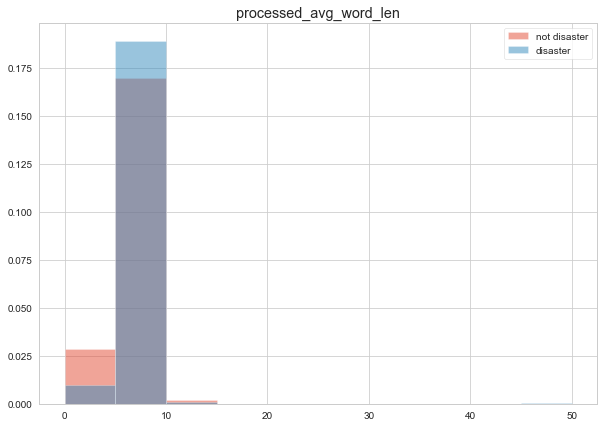

In [11]:
for column in train.columns[16:]:
    hist_plot_function(column)

In [12]:
round(train.describe(), 2)

,target,tweet_len,hashtag_count,hashtag_yn,mention_count,mention_yn,punctuation_count,punctuation_yn,word_count,unique_word_count,stopword_count,url_count,url_yn,avg_word_len,processed_tweet_len,processed_word_count,processed_unique_word_count,processed_avg_word_len
count,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00,7613.00
mean,0.43,87.11,0.45,0.23,0.36,0.27,6.84,0.96,14.90,14.34,4.52,0.62,0.52,6.13,51.24,8.34,8.14,6.24
std,0.50,29.15,1.10,0.42,0.72,0.44,4.61,0.21,5.73,5.28,3.42,0.66,0.50,1.68,21.06,3.39,3.26,1.76
min,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,2.25,0.00,0.00,0.00,0.00
25%,0.00,67.00,0.00,0.00,0.00,0.00,3.00,1.00,11.00,11.00,2.00,0.00,0.00,4.88,36.00,6.00,6.00,5.45
50%,0.00,92.00,0.00,0.00,0.00,0.00,6.00,1.00,15.00,14.00,4.00,1.00,1.00,5.93,52.00,8.00,8.00,6.10
75%,1.00,114.00,0.00,0.00,1.00,1.00,10.00,1.00,19.00,18.00,7.00,1.00,1.00,7.06,67.00,11.00,11.00,6.80
max,1.00,138.00,13.00,1.00,8.00,1.00,61.00,1.00,31.00,29.00,19.00,4.00,1.00,19.33,118.00,21.00,20.00,50.00


In [13]:
round(train[train['target']==0].describe(), 2)

,target,tweet_len,hashtag_count,hashtag_yn,mention_count,mention_yn,punctuation_count,punctuation_yn,word_count,unique_word_count,stopword_count,url_count,url_yn,avg_word_len,processed_tweet_len,processed_word_count,processed_unique_word_count,processed_avg_word_len
count,4342.0,4342.00,4342.00,4342.0,4342.00,4342.00,4342.00,4342.00,4342.00,4342.00,4342.00,4342.00,4342.00,4342.00,4342.00,4342.00,4342.00,4342.00
mean,0.0,81.98,0.39,0.2,0.43,0.31,6.31,0.94,14.70,14.10,4.82,0.51,0.41,5.87,47.54,7.98,7.81,6.05
std,0.0,30.80,1.01,0.4,0.78,0.46,4.83,0.24,6.16,5.65,3.63,0.67,0.49,1.74,21.43,3.55,3.43,1.65
min,0.0,6.00,0.00,0.0,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,2.25,0.00,0.00,0.00,0.00
25%,0.0,58.00,0.00,0.0,0.00,0.00,3.00,1.00,10.00,10.00,2.00,0.00,0.00,4.60,31.00,5.00,5.00,5.25
50%,0.0,87.00,0.00,0.0,0.00,0.00,6.00,1.00,15.00,14.00,4.00,0.00,0.00,5.54,48.00,8.00,8.00,5.90
75%,0.0,110.00,0.00,0.0,1.00,1.00,9.00,1.00,19.00,18.00,7.00,1.00,1.00,6.82,64.00,11.00,10.00,6.60
max,0.0,138.00,11.00,1.0,8.00,1.00,61.00,1.00,31.00,29.00,19.00,4.00,1.00,16.86,116.00,19.00,19.00,50.00


In [14]:
round(train[train['target']==1].describe(), 2)

,target,tweet_len,hashtag_count,hashtag_yn,mention_count,mention_yn,punctuation_count,punctuation_yn,word_count,unique_word_count,stopword_count,url_count,url_yn,avg_word_len,processed_tweet_len,processed_word_count,processed_unique_word_count,processed_avg_word_len
count,3271.0,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00,3271.00
mean,1.0,93.91,0.52,0.27,0.28,0.21,7.54,0.98,15.17,14.66,4.13,0.77,0.66,6.47,56.15,8.83,8.58,6.48
std,0.0,25.26,1.21,0.44,0.63,0.40,4.20,0.14,5.10,4.71,3.07,0.63,0.47,1.52,19.49,3.10,2.96,1.86
min,1.0,13.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00
25%,1.0,77.00,0.00,0.00,0.00,0.00,5.00,1.00,11.00,11.00,2.00,0.00,0.00,5.48,42.00,7.00,6.00,5.75
50%,1.0,100.00,0.00,0.00,0.00,0.00,7.00,1.00,15.00,15.00,3.00,1.00,1.00,6.35,56.00,9.00,9.00,6.36
75%,1.0,116.50,1.00,1.00,0.00,0.00,10.00,1.00,19.00,18.00,6.00,1.00,1.00,7.31,70.00,11.00,11.00,7.00
max,1.0,134.00,13.00,1.00,5.00,1.00,27.00,1.00,30.00,28.00,17.00,3.00,1.00,19.33,118.00,21.00,20.00,50.00
